<a href="https://colab.research.google.com/github/AgustinGurvich/TMD/blob/main/TMD_TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’




 sp      sex         index            FL              RW              CL       
 B:100   F:100   Min.   : 1.0   Min.   : 7.20   Min.   : 6.50   Min.   :14.70  
 O:100   M:100   1st Qu.:13.0   1st Qu.:12.90   1st Qu.:11.00   1st Qu.:27.27  
                 Median :25.5   Median :15.55   Median :12.80   Median :32.10  
                 Mean   :25.5   Mean   :15.58   Mean   :12.74   Mean   :32.11  
                 3rd Qu.:38.0   3rd Qu.:18.05   3rd Qu.:14.30   3rd Qu.:37.23  
                 Max.   :50.0   Max.   :23.10   Max.   :20.20   Max.   :47.60  
       CW              BD       
 Min.   :17.10   Min.   : 6.10  
 1st Qu.:31.50   1st Qu.:11.40  
 Median :36.80   Median :13.90  
 Mean   :36.41   Mean   :14.03  
 3rd Qu.:42.00   3rd Qu.:16.60  
 Max.   :54.60   Max.   :21.60  

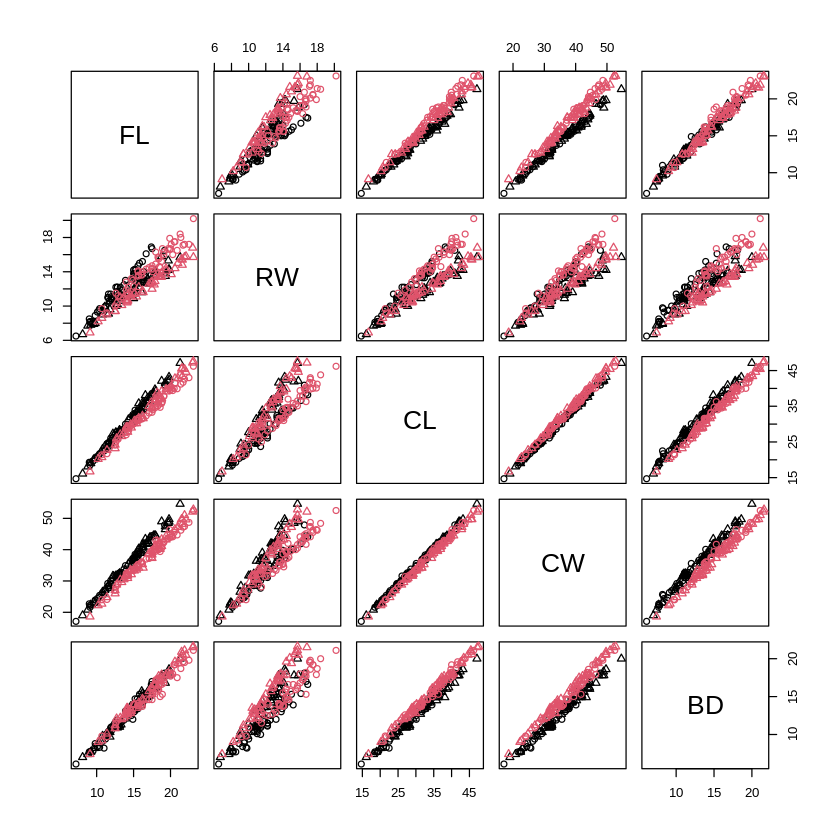

In [1]:
library(MASS)
install.packages("e1071") 
library(e1071)
data(crabs)
summary(crabs)
plot(crabs[,4:8],col=as.numeric(crabs[,1]),pch=as.numeric(crabs[,2]))
crabs.vars <- crabs[,4:8] #Sacamos las variables para usarlas

Cluster sin hacer nada con los datos, evidentemente no funciona

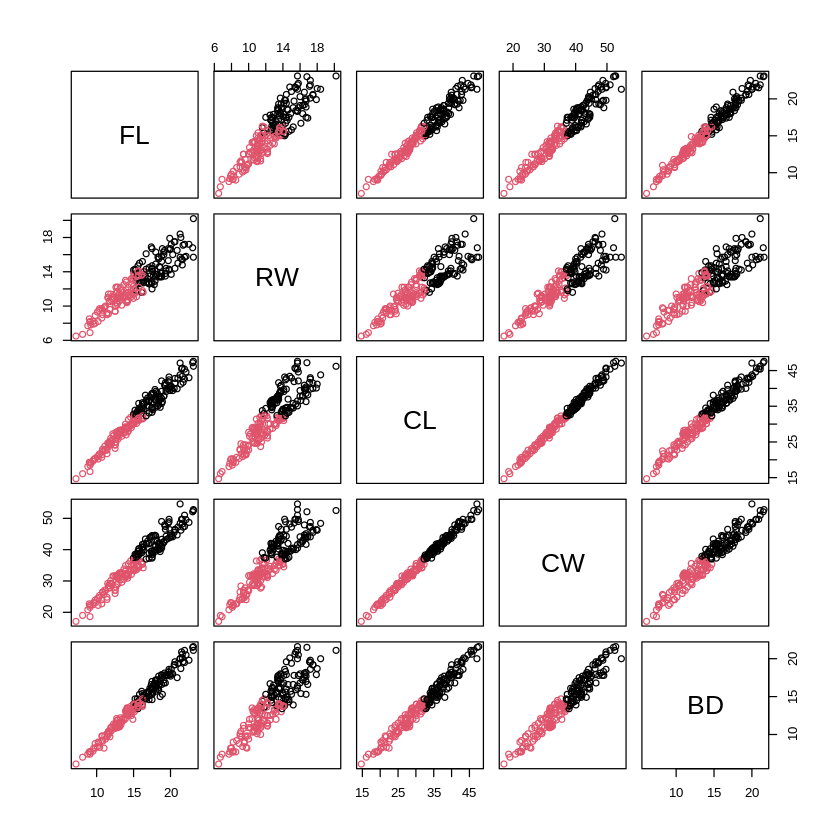

In [52]:
crabs.vars.kmeans <- kmeans(crabs.vars,cent=2)
plot(crabs.vars, col = crabs.vars.kmeans$cluster)

check.cluster <- function(cc){
  cont.table <- table(crabs.vars.kmeans$cluster,cc$cluster)
  class.match <- matchClasses(as.matrix(cont.table),method="exact")
  print(cont.table[,class.match])
  print(cont.table)
}

Cluster aplicando escala logaritmica a TODOS los datos, no se ven mejoras en el proceso

Direct agreement: 2 of 2 pairs
Cases in matched pairs: 85.5 %
   
     2  1
  1 96  0
  2 29 75
   
     1  2
  1  0 96
  2 75 29


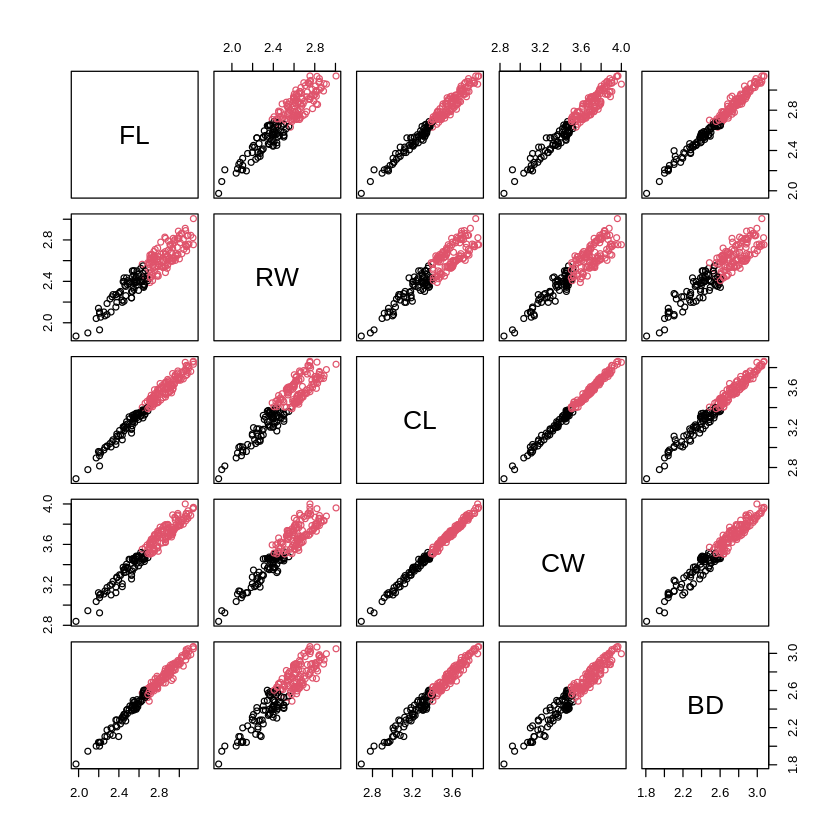

In [53]:
crabs.vars.log <- log(crabs.vars)
cc <- kmeans(crabs.vars.log,cent=2)
plot(crabs.vars.log, col = cc$cluster)
check.cluster(cc)

Escalamos las variables

Direct agreement: 2 of 2 pairs
Cases in matched pairs: 85.5 %
   
     1  2
  1 96  0
  2 29 75
   
     1  2
  1 96  0
  2 29 75


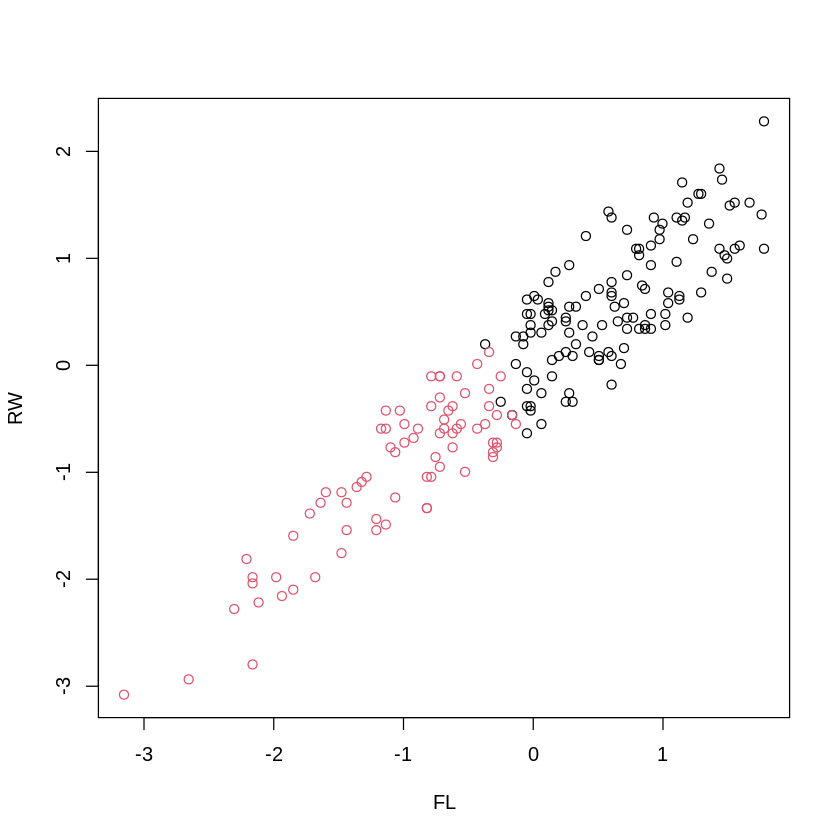

In [56]:
crabs.vars.log.scale <- scale(crabs.vars.log)
cc <- kmeans(crabs.vars.log.scale,cent=2)
plot(crabs.vars.log.scale, col = cc$cluster)
check.cluster(cc)

Aplicamos PCA para buscar las mejores variables

Direct agreement: 2 of 2 pairs
Cases in matched pairs: 85.5 %
   
     1  2
  1 96  0
  2 29 75
   
     1  2
  1 96  0
  2 29 75


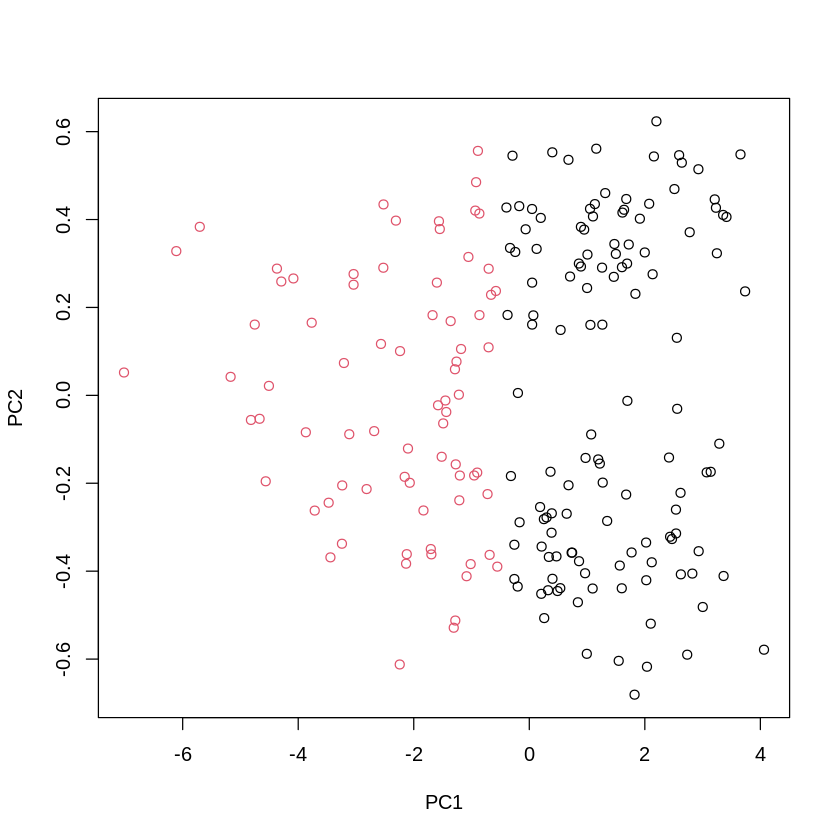

In [55]:
crabs.vars.log.pca <- prcomp(crabs.vars.log.scale)
cc <- kmeans(crabs.vars.log.pca$x,cent=2)
plot(crabs.vars.log.pca$x, col = cc$cluster)
check.cluster(cc)

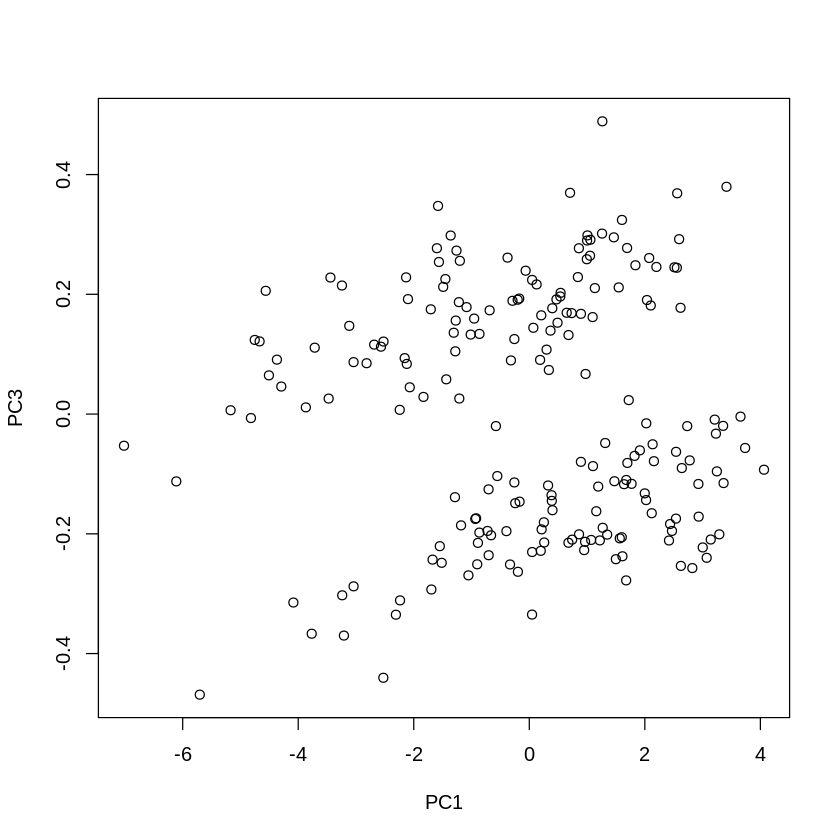

Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 59.5 %
   
     2  1
  1 57 39
  2 42 62
   
     1  2
  1 39 57
  2 62 42


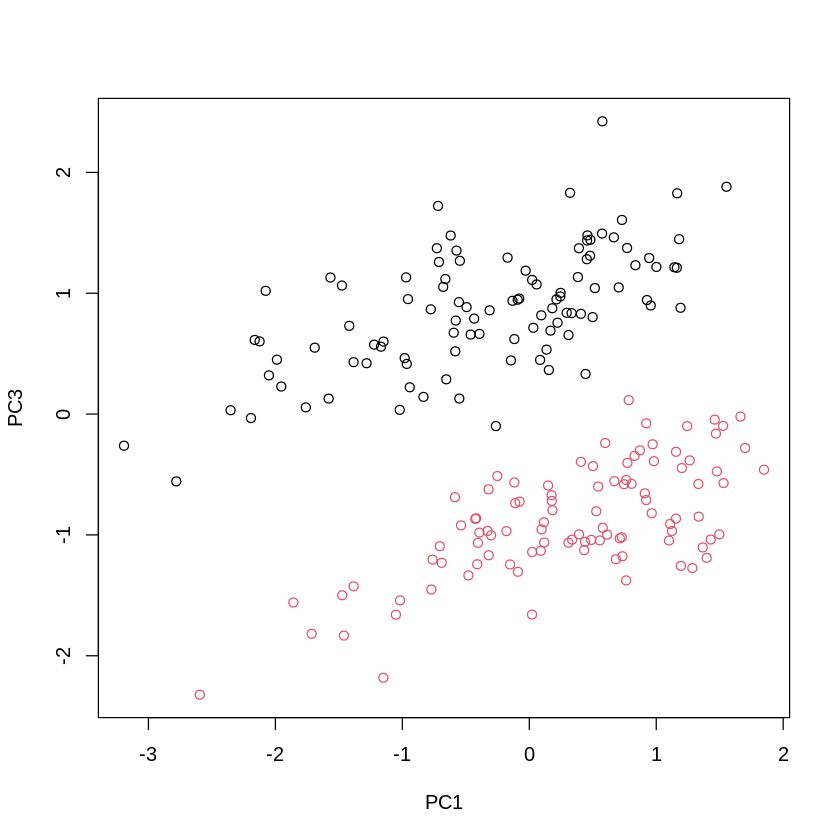

In [129]:
# c34 <- scale(log(crabs.vars[3:4]))
# c2 <- prcomp(c)
# print(c2$x)
# plot(c2)
# c3 <- scale(c2$x)
# cc <- kmeans(c34,cent=2)
# plot(c34, col = cc$cluster)
c <- scale(log(crabs.vars))
c2 <- prcomp(c)
plot(c2$x[,c(1,3)])
cosa <- c2$x[,c(1,3)]
cosa <- scale(cosa)
cc <- kmeans(cosa,cent=2)
plot(cosa, col = cc$cluster)
check.cluster(cc)

Funciones auxiliares para los métodos de clustering

In [18]:
crea.referencias <- function(original.dataset, n){
    #Dimensiones del dataset
    rows <- dim(original.dataset)[1]
    cols <- dim(original.dataset)[2]

    #Calculamos la pca
    pca <- prcomp(original.dataset)
    #Obtenemos los rangos de las variables, range me da el minimo y el maximo
    rangos <- apply(original.dataset, 2, range)

    #Dataset de referencia
    reference.datasets <- list()

    #Generamos los n datasets de referencia
    for(i in 1:n){
        #Generamos un dataset de referencia vacio
        reference.dataset <- c()

        #Generamos los valores de uno de los datasets
        for(j in 1:cols){
            reference.dataset.column <- runif(rows, rangos[1,j], rangos[2,j])
            reference.dataset <- cbind(reference.dataset, reference.dataset.column)
        }
        
        #Añadimos el dataset de referencia a la lista
        reference.datasets[[i]] <- reference.dataset
    }

    return (reference.datasets)
}
# crea.referencia(crabs.vars.log, 2)

stability.score <- function(n, ind1, ind2, cc1, cc2){
    v1 <- v2 <- rep(0,n)
    v1[ind1] <- cc1
    v2[ind2] <- cc2
    #creo una matriz m con 1 donde los dos puntos estan en el mismo cluster, -1 en distinto cluster y 0 si alguno no esta, para cada clustering
    a <- sqrt(v1%*%t(v1))
    m1 <- a / -a + 2*(a==round(a))
    m1[is.nan(m1)]<- 0
    a <- sqrt(v2%*%t(v2))
    m2 <- a / -a + 2*(a==round(a))
    m2[is.nan(m2)] <- 0
    #calculo el score, los pares de puntos que estan en la misma situacion en los dos clustering dividido el total de pares validos.
    validos <- sum(v1*v2>0)
    score <- sum((m1*m2)[upper.tri(m1)]>0)/(validos*(validos-1)/2)
    return(score)
}

create.kmeans <- function(dataset, k){
    #Generate k kmeans models
    kmeans.models <- double(k)
    for(i in 1:k){
        kmeans.i <- kmeans(dataset, i,nsta=10)
        kmeans.models[i] <-kmeans.i$tot.withinss
    }
    # matplot(1:k,kmeans.models,type='b')

    return(kmeans.models)
}

create.kmeans(crabs.vars.log, 10)

[1] 55.096697 19.465422 10.432332  6.525466  5.076294  3.920450  3.421647
 [8]  3.052044  2.721790  2.430534

Gap Statistic

In [34]:
#No funciona, sentarse con paciencia a debugear
gap.statistic <- function(dataset, k, uniform.reference){
    #Calculamos todos los saltos
    kmeans.jumps <- create.kmeans(dataset, k)

    #Creamos las referencias uniformes y calculamos sus saltos
    uniform.references <- crea.referencias(dataset, uniform.reference)
    uniform.jumps <- list()
    for(i in 1:uniform.reference){
        uniform.jumps[[i]] <- create.kmeans(uniform.references[[i]], k)
    }

    #Calculamos la estadistica Gap
    gap <- double(k)
    gap.deviation <- double(k)
    for(i in 1:k){
        #Obtenemos todos los saltos de las referencias uniformes de tamaño k
        uniform.jumps.k <- double(uniform.reference)
        for(j in 1:uniform.reference){
            uniform.jumps.k[j] <- uniform.jumps[[j]][i]
        }

        l.hat <- 1/uniform.reference * sum(log(uniform.jumps.k))
        gap[i] <- l.hat  - log(kmeans.jumps[i])
        sd.k <- sqrt(1/uniform.reference * sum((log(uniform.jumps.k) - l.hat)^2))
        gap.deviation[i] <- sd.k * sqrt(1 + 1/uniform.reference)
    }

    #Buscamos el numero de clusters sugerido siguiendo la desigualdad
    suggested.clusters <- 1
	while(suggested.clusters < k && 
	      gap[suggested.clusters] < gap[suggested.clusters + 1] - gap.deviation[suggested.clusters + 1]){
		suggested.clusters = suggested.clusters + 1
	}

  return(list(gaps = gap,
	            gap.deviations = gap.deviation,
	            suggested.clusters = suggested.clusters))
}

gap.statistic(crabs.vars.log, 10, 10)


$gaps
 [1] 0.7280335 1.5672600 2.0513756 2.3949410 2.5399756 2.7023599 2.7564480
 [8] 2.8065335 2.8349177 2.8222311

$gap.deviations
 [1] 0.03883588 0.03359673 0.03312429 0.02930740 0.02817247 0.02547319
 [7] 0.02548368 0.02998214 0.03452594 0.03419875

$suggested.clusters
[1] 8